In [1]:
from __future__ import print_function

# Import the Time Series library
import statsmodels.tsa.stattools as ts

# Import Datetime and the Pandas DataReader
from datetime import datetime

import yfinance as yf

# Download the Amazon OHLCV data from 1/1/2000 to 1/1/2015
amzn = yf.download("AMZN", datetime(2000,1,1), datetime(2015,1,1))

# Output the results of the Augmented Dickey-Fuller test for Amazon
# with a lag order value of 1
ts.adfuller(amzn['Adj Close'], 1)

[*********************100%***********************]  1 of 1 completed


(0.04917754919243893,
 0.962414944369521,
 1,
 3771,
 {'1%': -3.4320852842548395,
  '5%': -2.8623067530084247,
  '10%': -2.5671781529820348},
 -3017.6964513699386)

### Testing for Stationarity

In [2]:
from __future__ import print_function
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn


def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = log(cumsum(randn(100000))+1000)
mr = log(randn(100000)+1000)
tr = log(cumsum(randn(100000)+1)+1000)

# Output the Hurst Exponent for each of the above series
# and the price of Amazon (the Adjusted Close price) for
# the ADF test given above in the article
print("Hurst(GBM): %s" % hurst(gbm))
print("Hurst(MR): %s" % hurst(mr))
print("Hurst(TR): %s" % hurst(tr))

# Assuming you have run the above code to obtain ’amzn’!
print("Hurst(AMZN): %s" % hurst(amzn['Adj Close']))

Hurst(GBM): 0.49435025727431425
Hurst(MR): -0.00025900892108743855
Hurst(TR): 0.9585783075904791
Hurst(AMZN): nan


C:\Users\Caíque Miranda\AppData\Local\Temp\ipykernel_21024\1158032745.py:16: RuntimeWarning: divide by zero encountered in log
  poly = polyfit(log(lags), log(tau), 1)


In [3]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

In [4]:
def plot_price_series(df, ts1, ts2):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()

    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
    ax.grid(True)

    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()

In [5]:
def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()

In [6]:
def plot_residuals(df):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label="Residuals")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
    ax.grid(True)

    fig.autofmt_xdate()

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()
    plt.plot(df["res"])
    plt.show()

In [7]:
start = '2012-01-01'
end = '2013-01-01'
xom = yf.download("XOM", start, end)
cvx = yf.download("CVX", start, end)
df = pd.DataFrame(index=cvx.index)
df["XOM"] = xom["Adj Close"]
df["CVX"] = cvx["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


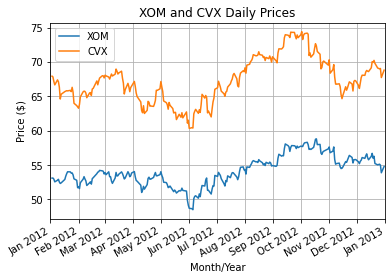

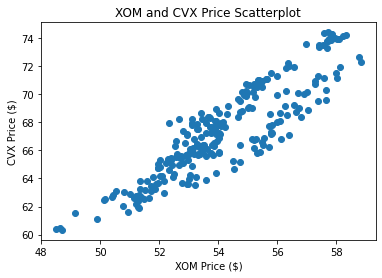

In [8]:
# Plot the two time series
plot_price_series(df, "XOM", "CVX")

# Display a scatter plot of the two time series
plot_scatter_series(df, "XOM", "CVX")

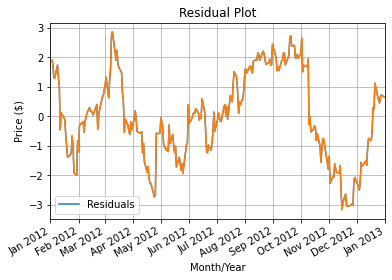

(-2.322574374433613,
 0.164790610902465,
 1,
 248,
 {'1%': -3.4569962781990573,
  '10%': -2.573018897632674,
  '5%': -2.8732659015936024},
 287.3700463337681)


In [22]:

# Calculate optimal hedge ratio "beta"
y = df['CVX'] 
x = df["XOM"]

model = sm.OLS(y, x)
results = model.fit()

beta_hr = results.params["XOM"]

# Calculate the residuals of the linear combination
df["res"] = df["CVX"] - beta_hr * df["XOM"]

# Plot the residuals
plot_residuals(df)

# Calculate and output the CADF test on the residuals
cadf = ts.adfuller(df["res"])
pprint.pprint(cadf)

### End.